In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn -q

In [2]:
# importing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from collections import defaultdict
from datetime import datetime
import json
import pandas as pd
import numpy as np

Unzipping the JSON Transactions

In [7]:
!unzip /content/user-wallet-transactions.json.zip -d /content

Archive:  /content/user-wallet-transactions.json.zip
  inflating: /content/user-wallet-transactions.json  
  inflating: /content/__MACOSX/._user-wallet-transactions.json  


In [8]:
# Load JSON data
with open('/content/user-wallet-transactions.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

In [9]:
# Viewing the action data dictionary for more clarity
df['actionData'][0]

{'type': 'Deposit',
 'amount': '2000000000',
 'assetSymbol': 'USDC',
 'assetPriceUSD': '0.9938318274296357543568636362026045',
 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174',
 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}

In [24]:
df.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt,actionData_amount,actionData_priceUSD,amount_usd
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,2021-08-17 05:29:26,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'},2.000000e+09,0.993832,1.987664e+09
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,2021-05-20 15:36:53,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'},1.450000e+20,1.970307,2.856945e+20
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,2021-07-24 09:28:33,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'},1.000000e+15,0.922377,9.223773e+14
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,2021-07-31 23:15:18,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'},4.000000e+15,1.057483,4.229933e+15
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,2021-04-19 15:25:07,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'},5.015480e+05,1.002130,5.026161e+05


### EDA (Exploaratory Data Analysis)
#### Converting the raw column data into structured data

In [11]:
# Convert timestamps to datetime and amounts to numeric (EDA)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['actionData_amount'] = df['actionData'].apply(lambda x: float(x['amount']))
df['actionData_priceUSD'] = df['actionData'].apply(lambda x: float(x['assetPriceUSD']))
df['amount_usd'] = df['actionData_amount'] * df['actionData_priceUSD']

In [12]:
df.info()
# print("NULL VALUE LIST",df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   _id                  100000 non-null  object        
 1   userWallet           100000 non-null  object        
 2   network              100000 non-null  object        
 3   protocol             100000 non-null  object        
 4   txHash               100000 non-null  object        
 5   logId                100000 non-null  object        
 6   timestamp            100000 non-null  datetime64[ns]
 7   blockNumber          100000 non-null  int64         
 8   action               100000 non-null  object        
 9   actionData           100000 non-null  object        
 10  __v                  100000 non-null  int64         
 11  createdAt            100000 non-null  object        
 12  updatedAt            100000 non-null  object        
 13  actionData_amou

### The Transaction Table dosent have any null values so we can proceed to Feature Engineering

## Feature Engineering

In [13]:
# Feature Engineering
def engineer_features(df):
    # Initializing the new feature columns (to give to model)
    wallets = defaultdict(lambda: {
        'num_transactions': 0,
        'num_deposits': 0,
        'total_deposit_usd': 0.0,
        'num_borrows': 0,
        'total_borrow_usd': 0.0,
        'num_repays': 0,
        'total_repay_usd': 0.0,
        'num_liquidations': 0,
        'total_liquidation_usd': 0.0,
        'num_redemptions': 0,
        'total_redemption_usd': 0.0,
        'unique_assets': set('USDC'),
        'time_span': 0,
        'borrow_to_deposit_ratio': 0.0,
        'repay_to_borrow_ratio': 0.0,
        'liquidation_to_borrow_ratio': 0.0
    })

    for _, row in df.iterrows():
        # Going through each row and updating the new column value for each userWallet (id)
        wallet = row['userWallet']
        action = row['action'].lower()
        amount_usd = row['amount_usd']
        asset = row['actionData']['assetSymbol']
        timestamp = row['timestamp']

        wallets[wallet]['num_transactions'] += 1
        wallets[wallet]['unique_assets'].add(asset)

        if action == 'deposit':
            wallets[wallet]['num_deposits'] += 1
            wallets[wallet]['total_deposit_usd'] += amount_usd
        elif action == 'borrow':
            wallets[wallet]['num_borrows'] += 1
            wallets[wallet]['total_borrow_usd'] += amount_usd
        elif action == 'repay':
            wallets[wallet]['num_repays'] += 1
            wallets[wallet]['total_repay_usd'] += amount_usd
        elif action == 'redeemunderlying':
            wallets[wallet]['num_redemptions'] += 1
            wallets[wallet]['total_redemption_usd'] += amount_usd
        elif action == 'liquidationcall':
            wallets[wallet]['num_liquidations'] += 1
            wallets[wallet]['total_liquidation_usd'] += amount_usd

    # Compute derived features
    wallet_features = []
    for wallet, stats in wallets.items():
        stats['time_span'] = (df[df['userWallet'] == wallet]['timestamp'].max() -
                              df[df['userWallet'] == wallet]['timestamp'].min()).days
        stats['borrow_to_deposit_ratio'] = (stats['total_borrow_usd'] / stats['total_deposit_usd']
                                            if stats['total_deposit_usd'] > 0 else 0)
        stats['repay_to_borrow_ratio'] = (stats['total_repay_usd'] / stats['total_borrow_usd']
                                          if stats['total_borrow_usd'] > 0 else 0)
        stats['liquidation_to_borrow_ratio'] = (stats['total_liquidation_usd'] / stats['total_borrow_usd']
                                                if stats['total_borrow_usd'] > 0 else 0)
        stats['num_unique_assets'] = len(stats['unique_assets'])
        wallet_features.append({
            'wallet': wallet,
            **{k: v for k, v in stats.items() if k != 'unique_assets'}
        })

    return pd.DataFrame(wallet_features)

* We are not using the other features as they are not useful for calculating the credit scores

In [25]:
# Generate features (call the function)
features_df = engineer_features(df)
features_df.head()

,wallet,num_transactions,num_deposits,total_deposit_usd,num_borrows,total_borrow_usd,num_repays,total_repay_usd,num_liquidations,total_liquidation_usd,num_redemptions,total_redemption_usd,time_span,borrow_to_deposit_ratio,repay_to_borrow_ratio,liquidation_to_borrow_ratio,num_unique_assets
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1,1,1.987664e+09,0,0.000000e+00,0,0.000000e+00,0,0.0,0,0.000000e+00,0,0.000000,0.000000e+00,0.0,5
1,0x000000000051d07a4fb3bd10121a343d85818da6,1,1,2.856945e+20,0,0.000000e+00,0,0.000000e+00,0,0.0,0,0.000000e+00,0,0.000000,0.000000e+00,0.0,5
2,0x000000000096026fb41fc39f9875d164bd82e2dc,2,2,5.152311e+15,0,0.000000e+00,0,0.000000e+00,0,0.0,0,0.000000e+00,7,0.000000,0.000000e+00,0.0,5
3,0x0000000000e189dd664b9ab08a33c4839953852c,17,0,0.000000e+00,0,0.000000e+00,0,0.000000e+00,0,0.0,17,9.803600e+20,129,0.000000,0.000000e+00,0.0,8
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,399,250,2.065773e+23,15,6.029762e+22,4,7.015026e+10,0,0.0,130,1.128745e+23,132,0.291889,1.163400e-12,0.0,10


In [15]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3497 entries, 0 to 3496
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   wallet                       3497 non-null   object 
 1   num_transactions             3497 non-null   int64  
 2   num_deposits                 3497 non-null   int64  
 3   total_deposit_usd            3497 non-null   float64
 4   num_borrows                  3497 non-null   int64  
 5   total_borrow_usd             3497 non-null   float64
 6   num_repays                   3497 non-null   int64  
 7   total_repay_usd              3497 non-null   float64
 8   num_liquidations             3497 non-null   int64  
 9   total_liquidation_usd        3497 non-null   float64
 10  num_redemptions              3497 non-null   int64  
 11  total_redemption_usd         3497 non-null   float64
 12  time_span                    3497 non-null   int64  
 13  borrow_to_deposit_

### Standardizing the features

In [16]:
feature_columns = [col for col in features_df.columns if col != 'wallet']

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(features_df[feature_columns])

In [17]:
X

array([[-0.1100772 , -0.32853316, -0.07061642, ..., -0.58634345,
         0.        , -0.74118358],
       [-0.1100772 , -0.32853316, -0.070449  , ..., -0.58634345,
         0.        , -0.74118358],
       [-0.10608831, -0.29504884, -0.07061642, ..., -0.58634345,
         0.        , -0.74118358],
       ...,
       [-0.09412164, -0.32853316, -0.04992454, ..., -0.58634345,
         0.        ,  0.78917598],
       [-0.02631049,  0.07327866, -0.0666355 , ..., -0.21267486,
         0.        ,  2.31953554],
       [ 0.61590103,  1.41265141,  0.12201436, ...,  0.34649855,
         0.        ,  2.31953554]])

## Model Building

In [89]:
# Step 1: Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomaly_labels = iso_forest.fit_predict(X)
anomaly_scores = iso_forest.score_samples(X)  # Lower is more anomalous

# Step 2: K-Means for non-anomalous wallets
non_anomalous_mask = anomaly_labels == 1
X_non_anomalous = X[non_anomalous_mask]
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_non_anomalous)

# Assign scores
scores = pd.Series(index=features_df['wallet'], dtype=float)

# Create ideal profile: max of positive features, min of negative features
ideal_profile = np.array([max(features_df[col]) if col in [
    'num_deposits', 'total_deposit_usd', 'num_repays', 'total_repay_usd',
    'repay_to_borrow_ratio', 'num_unique_assets', 'time_span'
] else min(features_df[col]) for col in feature_columns])

# Standardize the ideal profile
ideal_profile = scaler.transform([ideal_profile])[0]

non_anomalous_wallets = features_df['wallet'][non_anomalous_mask].reset_index(drop=True)
X_non_anomalous_df = pd.DataFrame(X_non_anomalous, index=non_anomalous_wallets)

# Compute Euclidean distances from each wallet to the ideal profile
distances = X_non_anomalous_df.apply(lambda row: np.linalg.norm(row - ideal_profile), axis=1)

# Normalize distances: lower = closer to ideal
min_dist = distances.min()
max_dist = distances.max()

# Min-Max Normalisation
normalized_distances = (distances - min_dist) / (max_dist - min_dist + 1e-6)  # avoid zero-division

# Apply exponential decay to spread scores more evenly
scaled_scores = 200 + 800 * np.exp(-3 * normalized_distances)

# Assign scores to non-anomalous wallets
for wallet, score in zip(non_anomalous_wallets, scaled_scores):
    scores[wallet] = round(score)

# Assign scores to anomalous wallets
for i, wallet in enumerate(features_df['wallet']):
    if anomaly_labels[i] == -1:
        score = max(0, 200 * (1 + anomaly_scores[i]))  # map to 0–200
        scores[wallet] = round(score)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [94]:
# Output scores
scores_df = pd.DataFrame({'wallet': scores.index, 'credit_score': scores.values})
scores_df.head(5)

,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,701.0
1,0x000000000051d07a4fb3bd10121a343d85818da6,701.0
2,0x000000000096026fb41fc39f9875d164bd82e2dc,705.0
3,0x0000000000e189dd664b9ab08a33c4839953852c,740.0
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,65.0


Graphical Distribution of Credit Scores by Anomoly Label

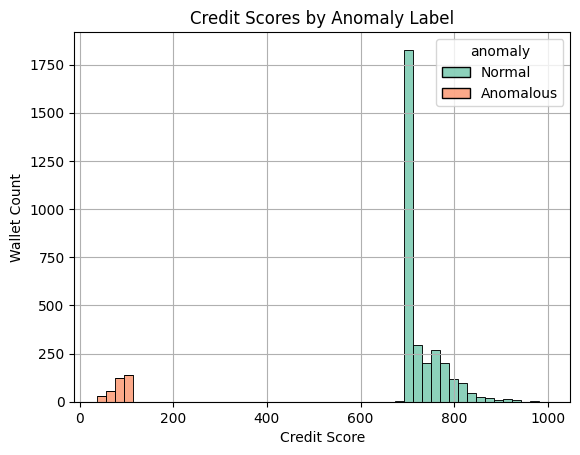

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
scores_df['anomaly'] = ['Anomalous' if lbl == -1 else 'Normal' for lbl in anomaly_labels]
sns.histplot(data=scores_df, x='credit_score', hue='anomaly', bins=50, palette='Set2', multiple='stack')
plt.title("Credit Scores by Anomaly Label")
plt.xlabel("Credit Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()



## **Conclusion**
* ### Anomalous wallets are still clearly isolated in the 0-200 range.

* ### Non-anomalous (Normal) wallets are spread from 600 to 1000.




In [33]:
scores_df.to_excel("output.xlsx")